In [ ]:
import tensorflow as tf
import numpy as np
np.random.seed(42)  # set global random generator
import os
import pandas as pd
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Layer, Input, Lambda, Conv2D, Dropout, Multiply, GlobalMaxPooling2D, MaxPooling2D, TimeDistributed, LSTM, Conv2DTranspose, concatenate, Concatenate, Dense, BatchNormalization, Activation, SeparableConv2D, add, Add, Multiply, SeparableConv2D, GlobalAveragePooling2D, DepthwiseConv2D, UpSampling2D, ZeroPadding2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import utils
import tensorflow.keras.backend as K
import matplotlib.pyplot as plt


#import math
#from sal_imp_utilities import *

import warnings

In [2]:
# Check if TensorFlow is using the Metal plugin (I'm using a Macbook Air with a built in 16-core Neural Engin, want to make sure I'm using that to ensure faster runtime)
print("TensorFlow is using Metal:", tf.config.list_physical_devices('GPU'))

TensorFlow is using Metal: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


# Data Preprocessing

In [3]:
# ---- Global Variables and Methods----
IMAGE_FOLDER = "images/"
SAL_MAP_FOLDER = "saliency_maps/"
CSV_FILE = 'image_types.csv'
IMG_SIZE = (224, 224, 3)

In [4]:
# ---- Data Generator ----
class DataGenerator(tf.keras.utils.Sequence):
    '''
    A custom data loader for the UI images and saliency maps, inheriting from tf.keras.utils.Sequence.
    For instance, can be used with the following methods:
        model.fit(train_data_gen, validation_data=val_data_gen, ...)
        predictions = model.predict(data_gen)
        loss, mae = model.evaluate(data_gen)
    '''
    def __init__(self, image_folder, sal_map_folder, filenames, batch_size=1, shuffle=True, sample_size=None):
        '''
        Constructor:
            image_folder (str): Path to the folder containing input images.
            sal_map_folder (str): Path to the folder containing saliency maps.
            filenames (list): List of filenames to include in this generator.
            batch_size (int): Number of samples per batch.
            shuffle (bool): Whether to shuffle the data at the end of each epoch.
            sample_size (int): Number of samples to use (for debugging).
        '''
        self.image_folder = image_folder # string, path to the folder containing input images
        self.sal_map_folder = sal_map_folder # string, path to the folder containing saliency maps
        self.batch_size = batch_size # int, number of samples per batch
        self.filenames = filenames # list of filenames (shared between the input images and their corresponding saliency maps) to convert to data
        self.sample_size = sample_size
        self.shuffle = shuffle # boolean, if using random shuffle each epoch

        # Limit the dataset to a (smaller) sample_size if specified
        if self.sample_size and self.sample_size<len(self.filenames):
            self.filenames = self.filenames[:self.sample_size]

        self.on_epoch_end() # random shuffle

    def on_epoch_end(self): # if using random shuffle each epoch
        '''If shuffle=True, shuffles the list of filenames to randomize the order of data for the next epoch (automatically called by Keras)'''
        if self.shuffle:
            np.random.shuffle(self.filenames)

    def __len__(self):
        '''Returns the number of batches per epoch'''
        return int(np.floor(len(self.filenames) / self.batch_size))

    def __getitem__(self, index):
        '''
        Generates one batch of data given the index of the batch (automatically called by Keras)
        Returns tuple (X, Y), both normalized to [0,1]
        X: batch of input images of shape (batch_size, height, width, channels)
        Y: batch of corresponding saliency maps of shape (batch_size, height, width, 1)
        
        Can be called using the [] indexing operator
        '''
        # select a subset of filenames for the current batch
        batch_files = self.filenames[index * self.batch_size:(index + 1) * self.batch_size]

        # load and preprocess the images and saliency maps for the specified batch
        return self.__data_generation(batch_files)
    
    def __data_generation(self, batch_files):
        '''
        Load and preprocess the images and saliency maps.
        Returns tuple (X, Y), both normalized to [0,1]
        X: batch of input images of shape (batch_size, height, width, channels)
        Y: batch of corresponding saliency maps of shape (batch_size, height, width, 1)
        '''
        X, Y = [], []
        for file in batch_files:
            # UI image
            img_path = os.path.join(self.image_folder, file)
            img = load_img(img_path, target_size=IMG_SIZE[:2]) # load and resize image to IMG_SIZE
            img = img_to_array(img) / 255.0 # convert images to arrays and normalize them to [0,1]
            
            # corresponding saliency map (grayscale)
            sal_path = os.path.join(self.sal_map_folder, file)
            sal_img = load_img(sal_path, target_size=IMG_SIZE[:2], color_mode="grayscale") # load and resize image to IMG_SIZE
            sal_img = img_to_array(sal_img) / 255.0 # convert images to arrays and normalize them to [0,1], use normalize()????
            
            X.append(img)
            Y.append(sal_img)

        return np.array(X), np.array(Y) # convert from list to np.arrays

In [5]:
# ---- Handle Missing Data ----
# Load the CSV file into a DataFrame
df = pd.read_csv(CSV_FILE, sep=',')

# Get the list of filenames from the CSV file, the image folder, and the saliency map folder
csv_filenames = set(df["Image Name"])
image_filenames = set(os.listdir(IMAGE_FOLDER))
sal_map_filenames = set(os.listdir(SAL_MAP_FOLDER))

print(f"There are {len(csv_filenames)} filenames in the CSV file.")
print(f"There are {len(image_filenames)} filenames in the Image folder.")
print(f"There are {len(sal_map_filenames)} filenames in the Saliency Map folder.")


# Find filenames that are missing in any of the three locations
missing_files = (csv_filenames | image_filenames | sal_map_filenames) - (csv_filenames & image_filenames & sal_map_filenames)

# Print missing filenames
if missing_files:
    print("The following filenames are missing in one or more locations:")
    for filename in missing_files:
        print(filename)
else:
    print("All filenames are present in all three locations.")

# Remove missing filenames from the CSV file
df = df[~df['Image Name'].isin(missing_files)]

print(f"Removed {len(missing_files)} filenames from the CSV file.\n")
print(f'Remaining Number of Data Samples:{df.shape[0]}')
print(f'Remaining Number of Desktop Samples:{df[df["Category"] == "desktop"].shape[0]}')
print(f'Remaining Number of Mobile Samples:{df[df["Category"] == "mobile"].shape[0]}')
print(f'Remaining Number of Web Samples:{df[df["Category"] == "web"].shape[0]}')
print(f'Remaining Number of Poster Samples:{df[df["Category"] == "poster"].shape[0]}')

There are 1463 filenames in the CSV file.
There are 1483 filenames in the Image folder.
There are 1924 filenames in the Saliency Map folder.
The following filenames are missing in one or more locations:
66058d.png
4bb6dd.png
7c5f7f.jpg
e7022f.png
4b3eb7.jpg
e1f7b0.jpg
eae3c4.jpg
48582c.png
c9ab98.jpg
6d8534.png
5c0bcf.png
ce9bfe.png
87475d.png
34c262.png
7cd2e0.jpg
c2a57a.png
6eb290.jpg
ab09c3.png
ab87f5.png
7aad84.png
80126c.png
e0966a.jpg
acfa9a.png
e228f3.jpg
0529f2.png
ad1e05.png
ab32c7.png
86500d.png
ed292f.png
fcac91.png
5d4c5e.png
c2c5ec.png
4ab184.png
e5174e.jpg
c5ea52.jpg
ed473c.png
6dacc6.jpg
cdbd16.png
520b4a.png
d499e7.png
5bfe3d.png
ad1260.jpg
5bcc14.jpg
d99b18.png
edbf2d.png
35c59b.png
49046b.png
4d0fc2.jpg
d7346d.png
46ced7.png
ffdc28.png
e5a7be.png
aac976.png
e471e8.png
574bac.png
ec6510.jpg
5d66d2.jpg
fff715.jpg
d09395.png
46bc27.jpg
da75d3.png
abb05d.jpg
a05750.png
df1857.png
6fd016.jpg
ed1239.png
511db2.png
37ad54.png
d889b1.png
4cd989.jpg
eb1040.png
501b73.jpg
f13c2

In [6]:
# ---- Initialize DataLoaders ----

# Filter by category if needed (desktop, poster, mobile, web) !!!
df = df[df['Category'] == "desktop"]

# Split the training data by randomly selecting valid_size*100% of the training data for validation
train_files = df[df['Train/Test'] == 'Train']['Image Name'].tolist()
valid_size = 0.2 # Split ratio
valid_indices = np.random.choice(len(train_files), int(len(train_files) * valid_size), replace=False)

# Get the list of...
valid_files = [train_files[i] for i in valid_indices] # validation filenames
train_files = [train_files[i] for i in range(len(train_files)) if i not in valid_indices] # training filenames
test_files = df[df['Train/Test'] == 'Test']['Image Name'].tolist() # testing filenames

# Check the number of batches in each generator
print("Number of training samples:", len(train_files))
print("Number of validation samples:", len(valid_files))
print("Number of test samples:", len(test_files))

# Initialize the training, validation, testing DataGenerators 
train_data_gen = DataGenerator(IMAGE_FOLDER, SAL_MAP_FOLDER, train_files)
valid_data_gen = DataGenerator(IMAGE_FOLDER, SAL_MAP_FOLDER, valid_files, shuffle=False) # no need to shuffle validation data
test_data_gen = DataGenerator(IMAGE_FOLDER, SAL_MAP_FOLDER, test_files, shuffle=False) # no need to shuffle test data

# Check the number of batches in each generator
print("Number of training batches:", len(train_data_gen))
print("Number of validation batches:", len(valid_data_gen))
print("Number of test batches:", len(test_data_gen))

# View the first batch of training data
batch1 = train_data_gen[0]
print("Training input batch shape:", batch1[0].shape)
print("Training saliency batch shape:", batch1[1].shape)

Number of training samples: 276
Number of validation samples: 69
Number of test samples: 18
Number of training batches: 276
Number of validation batches: 69
Number of test batches: 18
Training input batch shape: (1, 224, 224, 3)
Training saliency batch shape: (1, 224, 224, 1)


# Defining Methods for Evaluating the Model Training Process and Performance

In [34]:
# Plot the learning curve
def plot_learning_curve(history):
    # Extract loss and metrics from the history object
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(1, len(loss) + 1)
    
    # Plot the loss curve (use combined loss!!!)
    plt.figure(figsize=(12, 5))
    
    plt.subplot(1, 2, 1)
    plt.plot(epochs, loss, 'bo-', label='Training Loss')
    plt.plot(epochs, val_loss, 'ro-', label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
        
    plt.tight_layout()
    plt.show()

In [8]:
# Function to visualize the original image, ground truth saliency map, and predicted saliency map
def visualize_results(model, data_gen, num_samples=5):
    plt.figure(figsize=(15, 5 * num_samples))
    
    for i in range(num_samples):
        # Get a new batch for each sample
        X, Y_sal = data_gen[i % len(data_gen)]  # Cycle through batches if num_samples > batch_size
        
        # Predict saliency map
        Y_pred = model.predict(X, verbose=0)
        
        # Original Image (already resized to IMG_SIZE in DataGenerator)
        plt.subplot(num_samples, 3, i * 3 + 1)
        plt.imshow(X[0])  # Only use the first sample in the batch
        plt.title("Original Image")
        plt.axis('off')
        
        # Ground Truth Saliency Map (already resized to IMG_SIZE in DataGenerator)
        plt.subplot(num_samples, 3, i * 3 + 2)
        plt.imshow(Y_sal[0].squeeze(), cmap='gray')  # Only use the first sample in the batch
        plt.title("Ground Truth Saliency Map")
        plt.axis('off')
        
        # Predicted Saliency Map (already resized to IMG_SIZE in DataGenerator)
        plt.subplot(num_samples, 3, i * 3 + 3)
        plt.imshow(Y_pred[0].squeeze(), cmap='gray')  # Only use the first sample in the batch
        plt.title("Predicted Saliency Map")
        plt.axis('off')
    
    plt.tight_layout()
    plt.show()

# Defining the Loss Terms and Model Evaluation Metrics

### Define various loss functions

In [9]:
def batch_mean_std_normalize(heatmap):
    '''
    Apply whitening algorithm, which is basically mean-std normalization but for each pixel???
    See https://en.wikipedia.org/wiki/Whitening_transformation
    This method is from 'sal_imp_utilities.py' written by the UEyes team, called 'whiten'
    '''
    return (heatmap - K.mean(heatmap)) / (K.epsilon() + K.std(heatmap))

In [10]:
def batch_min_max_sum_normalize(heatmap):
    '''
    Min-Max scaling
    Sum Normalize heatmap values in the [0,1] range across entire tensor (batch).
    This method is from 'sal_imp_utilities.py' written by the UEyes team, called 'normalize'.
    '''

    # Apply mimaxscaler algorithm (https://en.wikipedia.org/wiki/Feature_scaling#Rescaling_(min-max_normalization))
    heatmap = (heatmap - K.min(heatmap)) / (K.epsilon() + K.max(heatmap) - K.min(heatmap))

    # Sum normalization
    heatmap /= (K.epsilon() + K.sum(heatmap))
    
    return heatmap

In [11]:
def max_sum_normalize(heatmap):
    '''
    Max scaling
    Sum Normalize heatmap values in the [0,1] range across each map in the tensor (batch).
    '''
    
    max_heatmap = K.repeat_elements(K.expand_dims(K.repeat_elements(K.expand_dims(K.max(K.max(heatmap, axis=1), axis=1), axis=1),
                                                                   IMG_SIZE[0], axis=1), axis=2), IMG_SIZE[1], axis=2)
    heatmap /= max_heatmap

    sum_heatmap = K.repeat_elements(K.expand_dims(K.repeat_elements(K.expand_dims(K.sum(K.sum(heatmap, axis=1), axis=1), axis=1),
                                                                   IMG_SIZE[0], axis=1), axis=2), IMG_SIZE[1], axis=2)
    heatmap /= (sum_heatmap + K.epsilon())

    return heatmap

In [12]:
def max_mean_std_normalize(heatmap):
    '''
    Max scaling
    Mean Std Normalize heatmap values in the [0,1] range across each map in the tensor (batch).
    '''
    max_heatmap = K.repeat_elements(K.expand_dims(K.repeat_elements(K.expand_dims(K.max(K.max(heatmap, axis=1), axis=1), axis=2), # axis=1???
                                                                    IMG_SIZE[0], axis=1), axis=2), IMG_SIZE[1], axis=2)

    heatmap /= max_heatmap

    heatmap_flatten = K.batch_flatten(heatmap)

    heatmap_mean = K.mean(heatmap_flatten, axis=-1)
    heatmap_mean = K.repeat_elements(K.expand_dims(K.repeat_elements(K.expand_dims(K.expand_dims(heatmap_mean)), 
                                                                     IMG_SIZE[0], axis=1)), IMG_SIZE[1], axis=2)

    heatmap_std = K.std(heatmap_flatten, axis=-1)
    heatmap_std = K.repeat_elements(K.expand_dims(K.repeat_elements(K.expand_dims(K.expand_dims(heatmap_std)), 
                                                                    IMG_SIZE[0], axis=1)), IMG_SIZE[1], axis=2)

    heatmap = (heatmap - heatmap_mean) / (heatmap_std + K.epsilon())

In [ ]:
def nss(y_true, y_pred):
    """
    Compute Normalized Scanpath Saliency (NSS) score.
    This method is from 'losses_keras2.py' written by the UEyes team.
    """
    ax = 1

    if K.all(K.equal(K.sum(K.sum(y_true, axis=ax), axis=ax), 0.0)):
        return 0.0

    max_y_pred = K.repeat_elements(K.expand_dims(K.repeat_elements(K.expand_dims(K.max(K.max(y_pred, axis=ax), axis=ax), axis=ax+1), IMG_SIZE[0], axis=ax), axis=ax+1), IMG_SIZE[1], axis=ax+1)

    y_pred /= max_y_pred

    y_pred_flatten = K.batch_flatten(y_pred)

    y_mean = K.mean(y_pred_flatten, axis=-1)
    y_mean = K.repeat_elements(K.expand_dims(K.repeat_elements(K.expand_dims(K.expand_dims(y_mean)), IMG_SIZE[0], axis=ax)), IMG_SIZE[1], axis=ax+1)

    y_std = K.std(y_pred_flatten, axis=-1)
    y_std = K.repeat_elements(K.expand_dims(K.repeat_elements(K.expand_dims(K.expand_dims(y_std)), IMG_SIZE[0], axis=ax)), IMG_SIZE[1], axis=ax+1)

    y_pred = (y_pred - y_mean) / (y_std + K.epsilon())

    den = K.sum(K.sum(y_true * y_pred, axis=ax), axis=ax)
    nom = K.sum(K.sum(y_true, axis=ax), axis=ax) + K.epsilon()

    nss_out = den/nom

    return nss_out

In [14]:
def correlation_coefficient(y_true, y_pred):
    """
    Compute Cross-Correlation (CC) score.
    This method is from 'losses_keras2.py' written by the UEyes team.
    """
    max_y_pred = K.repeat_elements(K.expand_dims(K.repeat_elements(K.expand_dims(K.max(K.max(y_pred, axis=1), axis=1), axis=1),
                                                                   IMG_SIZE[0], axis=1), axis=2), IMG_SIZE[1], axis=2)
    y_pred /= max_y_pred

    sum_y_true = K.repeat_elements(K.expand_dims(K.repeat_elements(K.expand_dims(K.sum(K.sum(y_true, axis=1), axis=1), axis=1),
                                                                   IMG_SIZE[0], axis=1), axis=2), IMG_SIZE[1], axis=2)
    sum_y_pred = K.repeat_elements(K.expand_dims(K.repeat_elements(K.expand_dims(K.sum(K.sum(y_pred, axis=1), axis=1), axis=1),
                                                                   IMG_SIZE[0], axis=1), axis=2), IMG_SIZE[1], axis=2)
    y_true /= (sum_y_true + K.epsilon())
    y_pred /= (sum_y_pred + K.epsilon())

    N = IMG_SIZE[0] * IMG_SIZE[1]
    sum_prod = K.sum(K.sum(y_true * y_pred, axis=1), axis=1)
    sum_x = K.sum(K.sum(y_true, axis=1), axis=1)
    sum_y = K.sum(K.sum(y_pred, axis=1), axis=1)
    sum_x_square = K.sum(K.sum(K.square(y_true), axis=1), axis=1)
    sum_y_square = K.sum(K.sum(K.square(y_pred), axis=1), axis=1)

    num = sum_prod - ((sum_x * sum_y) / N)
    den = K.sqrt((sum_x_square - K.square(sum_x) / N) * (sum_y_square - K.square(sum_y) / N))

    return num / den

In [15]:
def similarity(y_true, y_pred):
    '''
    Compute Similarity score.
    This method is from 'losses_keras2.py' written by the UEyes team.
    '''
    y_pred = batch_min_max_sum_normalize(y_pred)
    y_true = batch_min_max_sum_normalize(y_true)

    return K.sum(K.minimum(y_pred, y_true))

In [ ]:
kl = tf.keras.losses.KLDivergence()
def kl_divergence(y_true, y_pred):
    '''
    Compute Kullback-Leibler divergence loss.
    This method is from 'losses_keras2.py' written by the UEyes team.
    '''

    max_y_pred = K.repeat_elements(K.expand_dims(K.repeat_elements(K.expand_dims(K.max(K.max(y_pred, axis=1), axis=1), axis=1),
                                                                   IMG_SIZE[0], axis=1), axis=2), IMG_SIZE[1], axis=2)
    y_pred /= max_y_pred

    sum_y_true = K.repeat_elements(K.expand_dims(K.repeat_elements(K.expand_dims(K.sum(K.sum(y_true, axis=1), axis=1), axis=1),
                                                                   IMG_SIZE[0], axis=1), axis=2), IMG_SIZE[1], axis=2)
    sum_y_pred = K.repeat_elements(K.expand_dims(K.repeat_elements(K.expand_dims(K.sum(K.sum(y_pred, axis=1), axis=1), axis=1),
                                                                   IMG_SIZE[0], axis=1), axis=2), IMG_SIZE[1], axis=2)
    y_true /= (sum_y_true + K.epsilon())
    y_pred /= (sum_y_pred + K.epsilon())
    
    return kl(y_true,y_pred)

In [17]:
#kl_divergence = tf.keras.losses.KLDivergence() # dont use??? bc input not normalized into probability distributions

In [18]:
mse = tf.keras.losses.MeanSquaredError()

### Combine different loss functions to form loss terms

In [74]:
def combined_loss(y_true, y_pred):
    '''
    Loss function that combines cc, nss and kl. Beacuse nss receives a different ground truth than kl and cc (maps), !!!
        the function requires y_true to contains both maps. It has to be a tensor with dimensions [bs, 2, r, c, 1]. y_pred also
        has to be a tensor of the same dim, so the model should add a 5th dimension between bs and r and repeat the predict map
        twice along that dim.
    This method is adapted from the method in 'losses_keras2.py' written by the UEyes team.
    Returns a combined loss term with the specified weights that can be used in model.compile().
    '''
    # loss term weights
    kl_weight=10.0
    cc_weight=3.0
    sim_weight=1.0
    nss_weight=0.5
    mse_weight=1

    # compute loss terms
    k = kl_divergence(y_true, y_pred)
    #c = correlation_coefficient(y_true, y_pred) # cc becoming nan values after 8 passes???
    n = nss(y_true, y_pred)
    s = similarity(y_true, y_pred)
    m = mse(y_true, y_pred) # tf.reduce_mean(tf.square(y_true - y_pred))
    
    # combined loss
    return kl_weight*k - nss_weight*n + mse_weight*m #- cc_weight*c - sim_weight*s

In [20]:
# debugging with two random size-16 batches of y predictions !!!
print(train_data_gen[3][1].shape)
nss(train_data_gen[0][1],train_data_gen[4][1])

(1, 224, 224, 1)
Metal device set to: Apple M1

systemMemory: 8.00 GB
maxCacheSize: 2.67 GB



2025-03-07 22:46:06.719683: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2025-03-07 22:46:06.719971: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


<tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[0.34061617]], dtype=float32)>

### Define various evaluation metrics

In [21]:
# Initialize the AUC metric once
auc = tf.keras.metrics.AUC()

def auc_judd(y_true, y_pred):
    """
    Compute AUC-Judd score.
    """
    
    # Flatten the saliency maps and fixation maps
    y_true_flat = tf.reshape(y_true, [-1])
    y_pred_flat = tf.reshape(y_pred, [-1])
    
    # Compute AUC using TensorFlow's AUC metric
    auc.update_state(y_true_flat, y_pred_flat)
    return auc.result()

In [22]:
def information_gain(y_true, y_pred):
    """
    Compute Information Gain (IG) score. (UEyes didn't give implementation for this???)
    """
    # Normalize y_pred and y_true
    y_pred = batch_min_max_sum_normalize(y_pred)
    y_true = batch_min_max_sum_normalize(y_true)
    
    # Compute log ratio
    log_ratio = K.log((y_pred + K.epsilon()) / (y_true + K.epsilon()))
    
    # Compute IG
    ig = K.sum(y_true * log_ratio, axis=[1, 2])
    return ig

# The Simplified Copycat UMSI++ Model

### Define the model architecture

In [ ]:
# Define the UMSI++ model
def UMSI_simple(input_shape=(224, 224, 3)):
    # Input layer
    inputs = Input(shape=input_shape)
    
    # --------------------------
    # Encoder (Feature Extraction)
    # --------------------------
    # Block 1
    x1 = Conv2D(32, (3, 3), activation='relu', padding='same', name='block1_conv1')(inputs)
    x1 = Conv2D(32, (3, 3), activation='relu', padding='same', name='block1_conv2')(x1)
    p1 = MaxPooling2D((2, 2), name='block1_pool')(x1)
    
    # Block 2
    x2 = Conv2D(64, (3, 3), activation='relu', padding='same', name='block2_conv1')(p1)
    x2 = Conv2D(64, (3, 3), activation='relu', padding='same', name='block2_conv2')(x2)
    p2 = MaxPooling2D((2, 2), name='block2_pool')(x2)
    
    # Block 3
    x3 = Conv2D(128, (3, 3), activation='relu', padding='same', name='block3_conv1')(p2)
    x3 = Conv2D(128, (3, 3), activation='relu', padding='same', name='block3_conv2')(x3)
    p3 = MaxPooling2D((2, 2), name='block3_pool')(x3)
    
    # --------------------------
    # Bottleneck (Multi-Scale Feature Aggregation)
    # --------------------------
    bottleneck = Conv2D(256, (3, 3), activation='relu', padding='same', name='bottleneck_conv1')(p3)
    bottleneck = Conv2D(256, (3, 3), activation='relu', padding='same', name='bottleneck_conv2')(bottleneck)
    
    # --------------------------
    # Decoder (Saliency Map Reconstruction)
    # --------------------------
    # Block 4
    u4 = Conv2DTranspose(128, (3, 3), strides=(2, 2), padding='same', name='block4_deconv')(bottleneck)
    u4 = concatenate([u4, x3], name='block4_concat')
    u4 = Conv2D(128, (3, 3), activation='relu', padding='same', name='block4_conv1')(u4)
    u4 = Conv2D(128, (3, 3), activation='relu', padding='same', name='block4_conv2')(u4)
    
    # Block 5
    u5 = Conv2DTranspose(64, (3, 3), strides=(2, 2), padding='same', name='block5_deconv')(u4)
    u5 = concatenate([u5, x2], name='block5_concat')
    u5 = Conv2D(64, (3, 3), activation='relu', padding='same', name='block5_conv1')(u5)
    u5 = Conv2D(64, (3, 3), activation='relu', padding='same', name='block5_conv2')(u5)
    
    # Block 6
    u6 = Conv2DTranspose(32, (3, 3), strides=(2, 2), padding='same', name='block6_deconv')(u5)
    u6 = concatenate([u6, x1], name='block6_concat')
    u6 = Conv2D(32, (3, 3), activation='relu', padding='same', name='block6_conv1')(u6)
    u6 = Conv2D(32, (3, 3), activation='relu', padding='same', name='block6_conv2')(u6)
    
    # --------------------------
    # Saliency Output
    # --------------------------
    saliency_output = Conv2D(1, (1, 1), activation='sigmoid', name='saliency_output')(u6)
    
    # --------------------------
    # Define the Model
    # --------------------------
    model = Model(inputs, saliency_output, name='UMSI_simple')  # Use a valid model name
    
    return model

# Build the model
UMSI_simple = UMSI_simple(input_shape=(224, 224, 3))

# Print model summary
UMSI_simple.summary()

Model: "umsi_plus_plus"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 block1_conv1 (Conv2D)          (None, 224, 224, 32  896         ['input_2[0][0]']                
                                )                                                                 
                                                                                                  
 block1_conv2 (Conv2D)          (None, 224, 224, 32  9248        ['block1_conv1[0][0]']           
                                )                                                    

### Training the Model (compile with the customized loss term and evaluation metrics)

In [24]:
combined_metrics=['accuracy',
         'mse', # Mean Squared Error
        auc_judd,  # AUC-Judd
        nss,       # Normalized Scanpath Saliency
        information_gain,  # Information Gain, or use crossentropy from keras????
        similarity,  # Similarity
        correlation_coefficient,  # Cross-Correlation
        kl_divergence]  # KL Divergence (built-in) #tf.keras.metrics.KLDivergence()???

Epoch 1/30


2025-03-07 22:49:23.454276: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


276/276 [==============================] - ETA: 0s - loss: -0.3111 - accuracy: 0.3701 - mse: 0.1628 - auc_judd: 0.5601 - nss: 0.9482 - information_gain: -0.7877 - similarity: 0.5180 - correlation_coefficient: 0.4955 - kl_divergence: 2.2010e-05

2025-03-07 22:50:17.654248: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


276/276 [==============================] - 60s 196ms/step - loss: -0.3111 - accuracy: 0.3701 - mse: 0.1628 - auc_judd: 0.5601 - nss: 0.9482 - information_gain: -0.7877 - similarity: 0.5180 - correlation_coefficient: 0.4955 - kl_divergence: 2.2010e-05 - val_loss: -0.4854 - val_accuracy: 0.4124 - val_mse: 0.0437 - val_auc_judd: 0.5684 - val_nss: 1.0586 - val_information_gain: -0.7528 - val_similarity: 0.5113 - val_correlation_coefficient: 0.5636 - val_kl_divergence: 1.6399e-05
Epoch 2/30
276/276 [==============================] - 45s 162ms/step - loss: -0.5275 - accuracy: 0.4227 - mse: 0.0221 - auc_judd: 0.5744 - nss: 1.0996 - information_gain: -0.7042 - similarity: 0.5549 - correlation_coefficient: 0.5725 - kl_divergence: 1.4171e-05 - val_loss: -0.5502 - val_accuracy: 0.4124 - val_mse: 0.0178 - val_auc_judd: 0.5925 - val_nss: 1.1363 - val_information_gain: -0.6455 - val_similarity: 0.5542 - val_correlation_coefficient: 0.6027 - val_kl_divergence: 1.2707e-05
Epoch 3/30
276/276 [=========

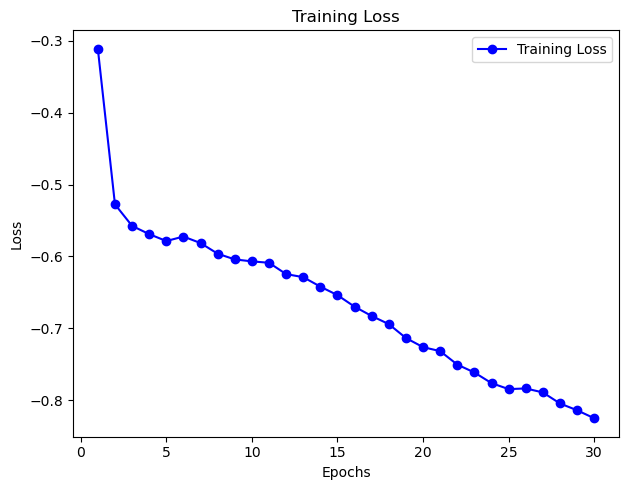

In [ ]:
# debugging!!!
opt = Adam(learning_rate=0.001)
UMSI_simple.compile(optimizer=opt, loss = combined_loss, metrics=combined_metrics)

# Train the model and capture the history
history = UMSI_simple.fit(train_data_gen, validation_data=valid_data_gen, epochs=30, steps_per_epoch=len(train_data_gen))
# Plot the learning curve
plot_learning_curve(history)

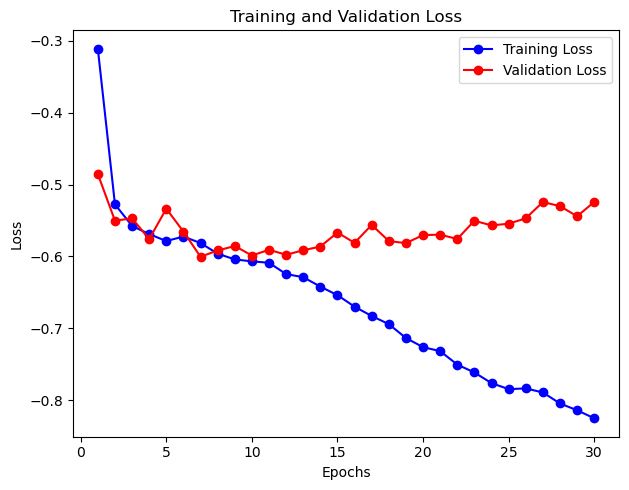

In [35]:
plot_learning_curve(history)

### Evaluate the Model's Performance on Training Data VS Test Data

##### Compare Performance Across Various Metrics

In [ ]:
# Compute performance on train data
performance_train = {}
for metric in UMSI_simple.metrics:
    result = metric.result()
    result = result.numpy().item()
    if isinstance(result, dict):
        performance_train.update(result)
    else:
        performance_train[metric.name] = result
performance_train = pd.DataFrame(performance_train,index=['Train'])

# Compute performance on test data
performance_test = UMSI_simple.evaluate(test_data_gen,return_dict=True, verbose=0)
performance_test = pd.DataFrame(performance_test,index=['Test'])

# Display results in a table
performance = pd.concat([performance_train, performance_test])
pd.set_option('display.float_format', '{:.15f}'.format)
performance

,loss,accuracy,mse,auc_judd,nss,information_gain,similarity,correlation_coefficient,kl_divergence
Train,-0.524168074131012,0.412407159805298,0.014987860806286,0.778290450572968,1.078583002090454,-0.620237171649933,0.570247113704681,0.567510604858398,0.000013572514945
Test,-0.549243688583374,0.453849107027054,0.016219705343246,0.778105974197388,1.131208896636963,-0.672409892082214,0.557790994644165,0.590863227844238,0.000014092178390


##### Compare Model's Predicted Maps with Ground Truth Maps with Training and Test Data

2025-03-07 23:19:26.200865: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


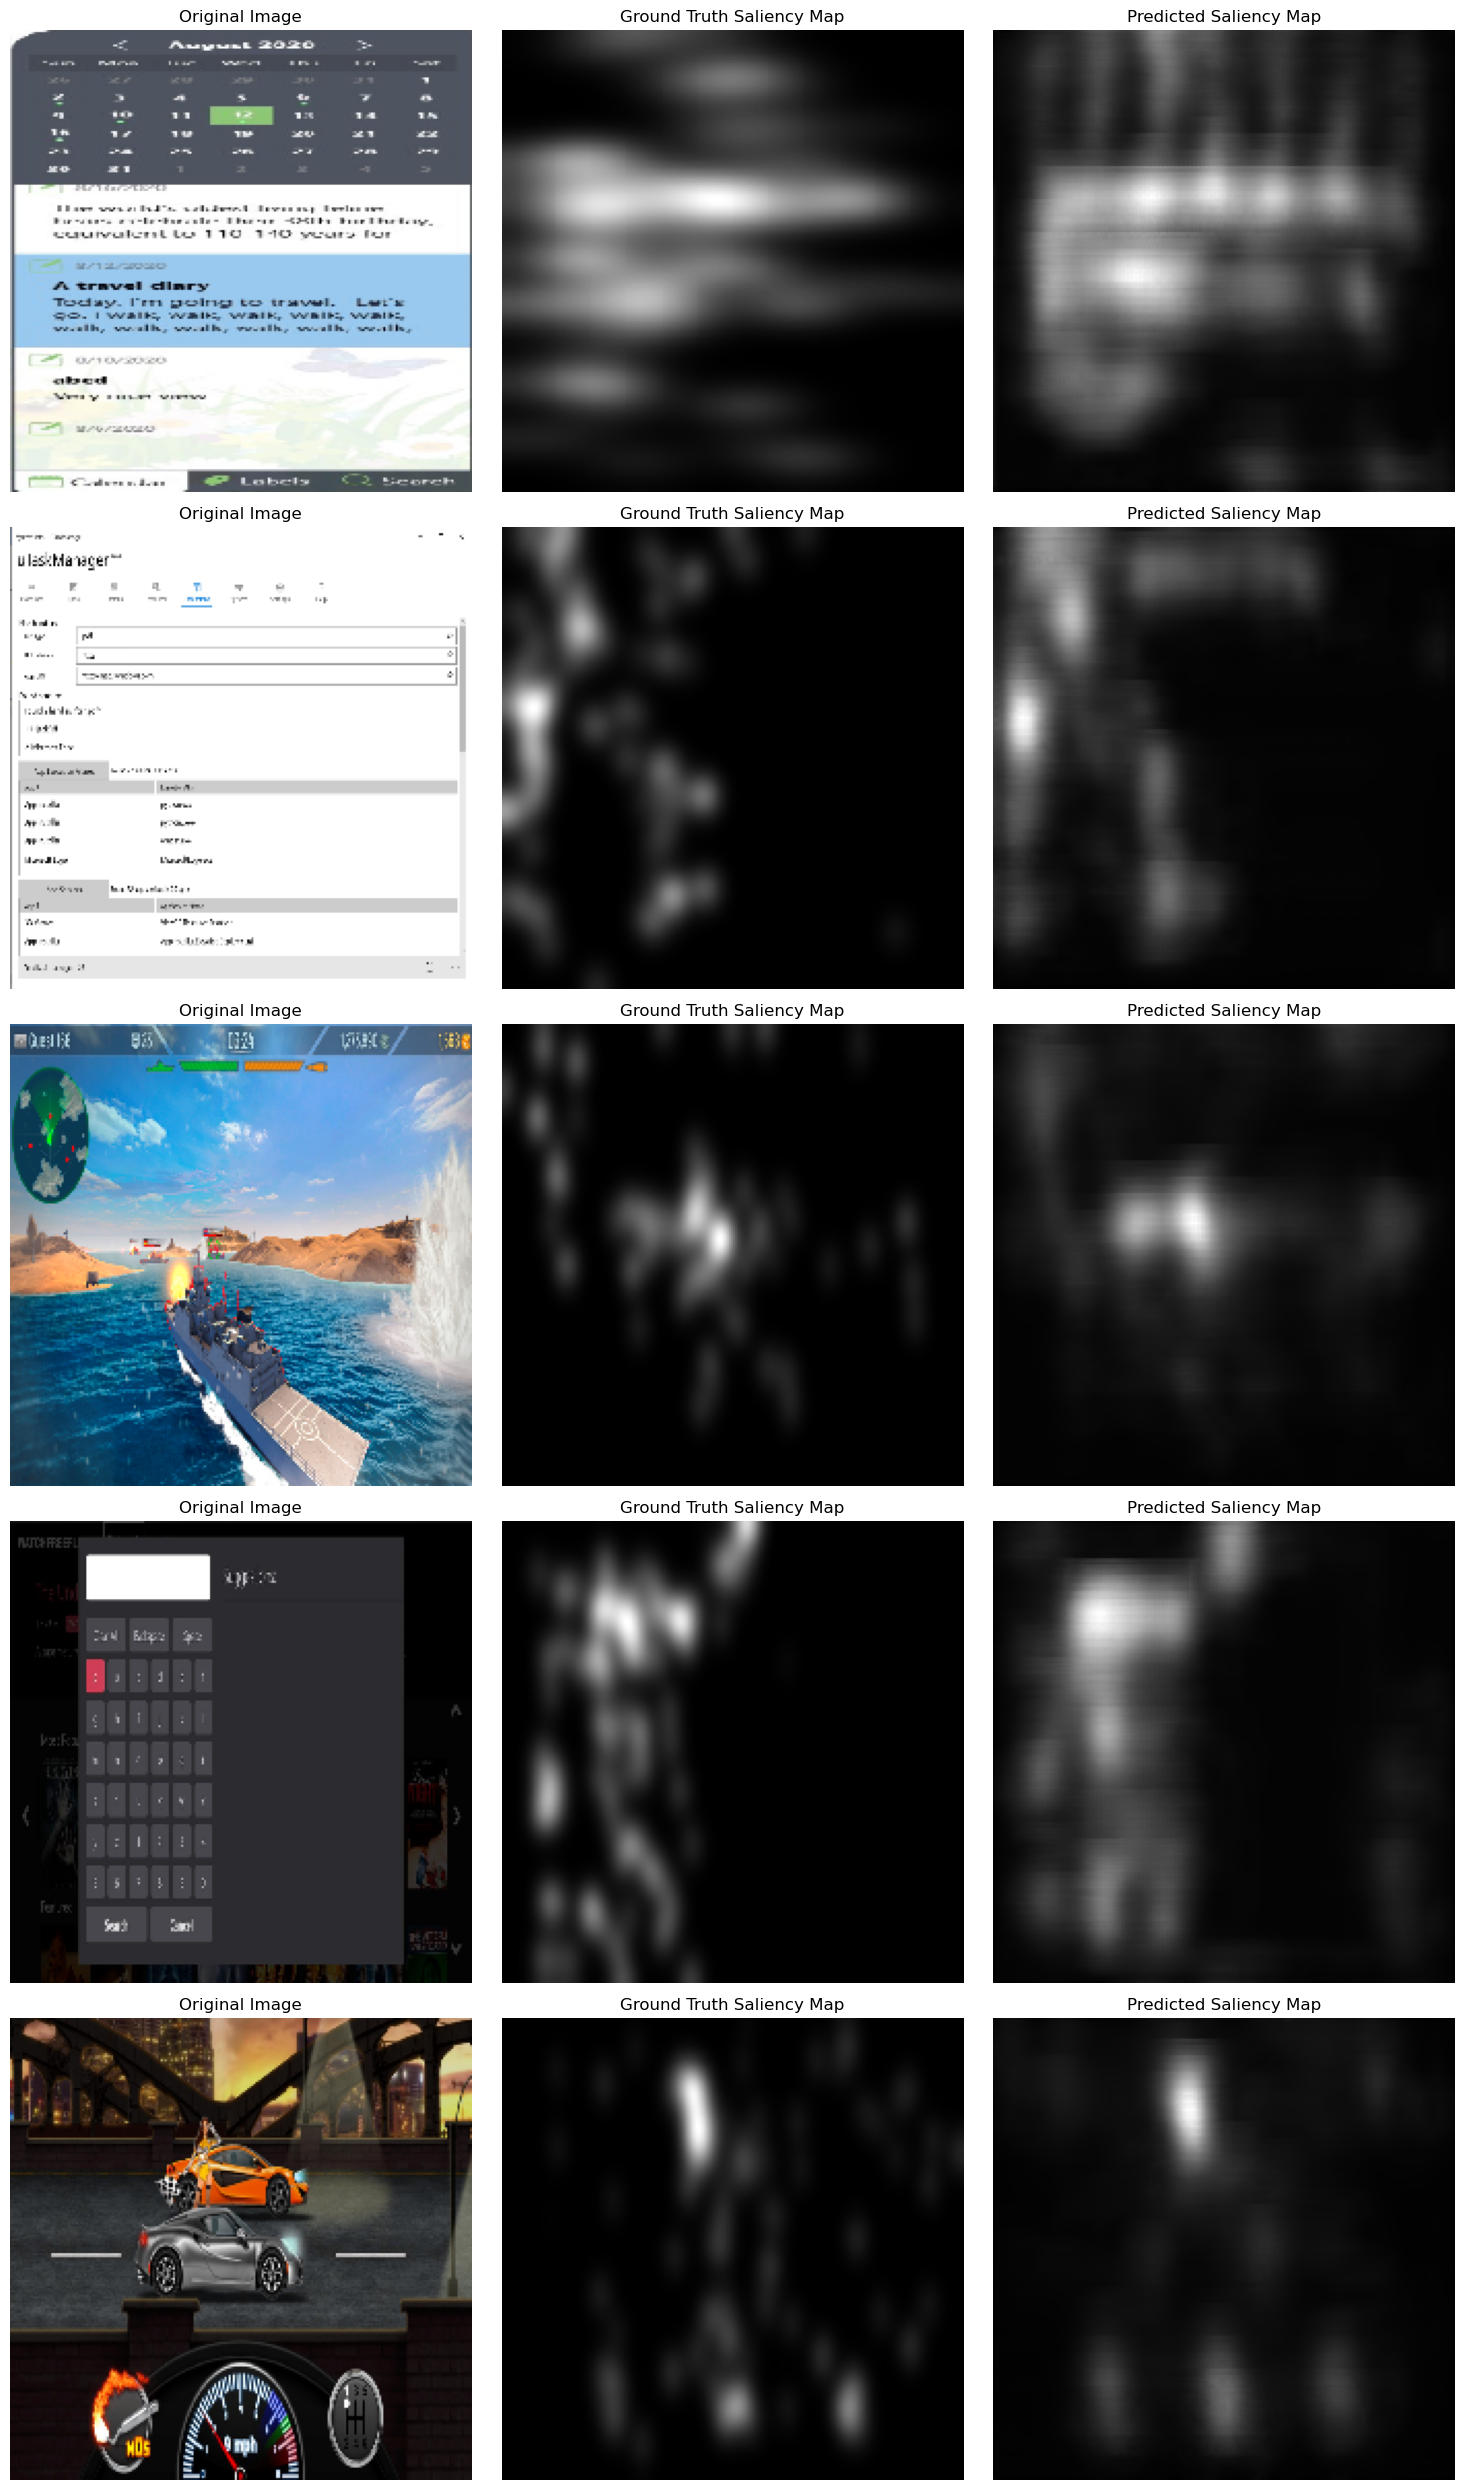

In [ ]:
visualize_results(UMSI_simple, train_data_gen, num_samples=5) # 5 random traning examples

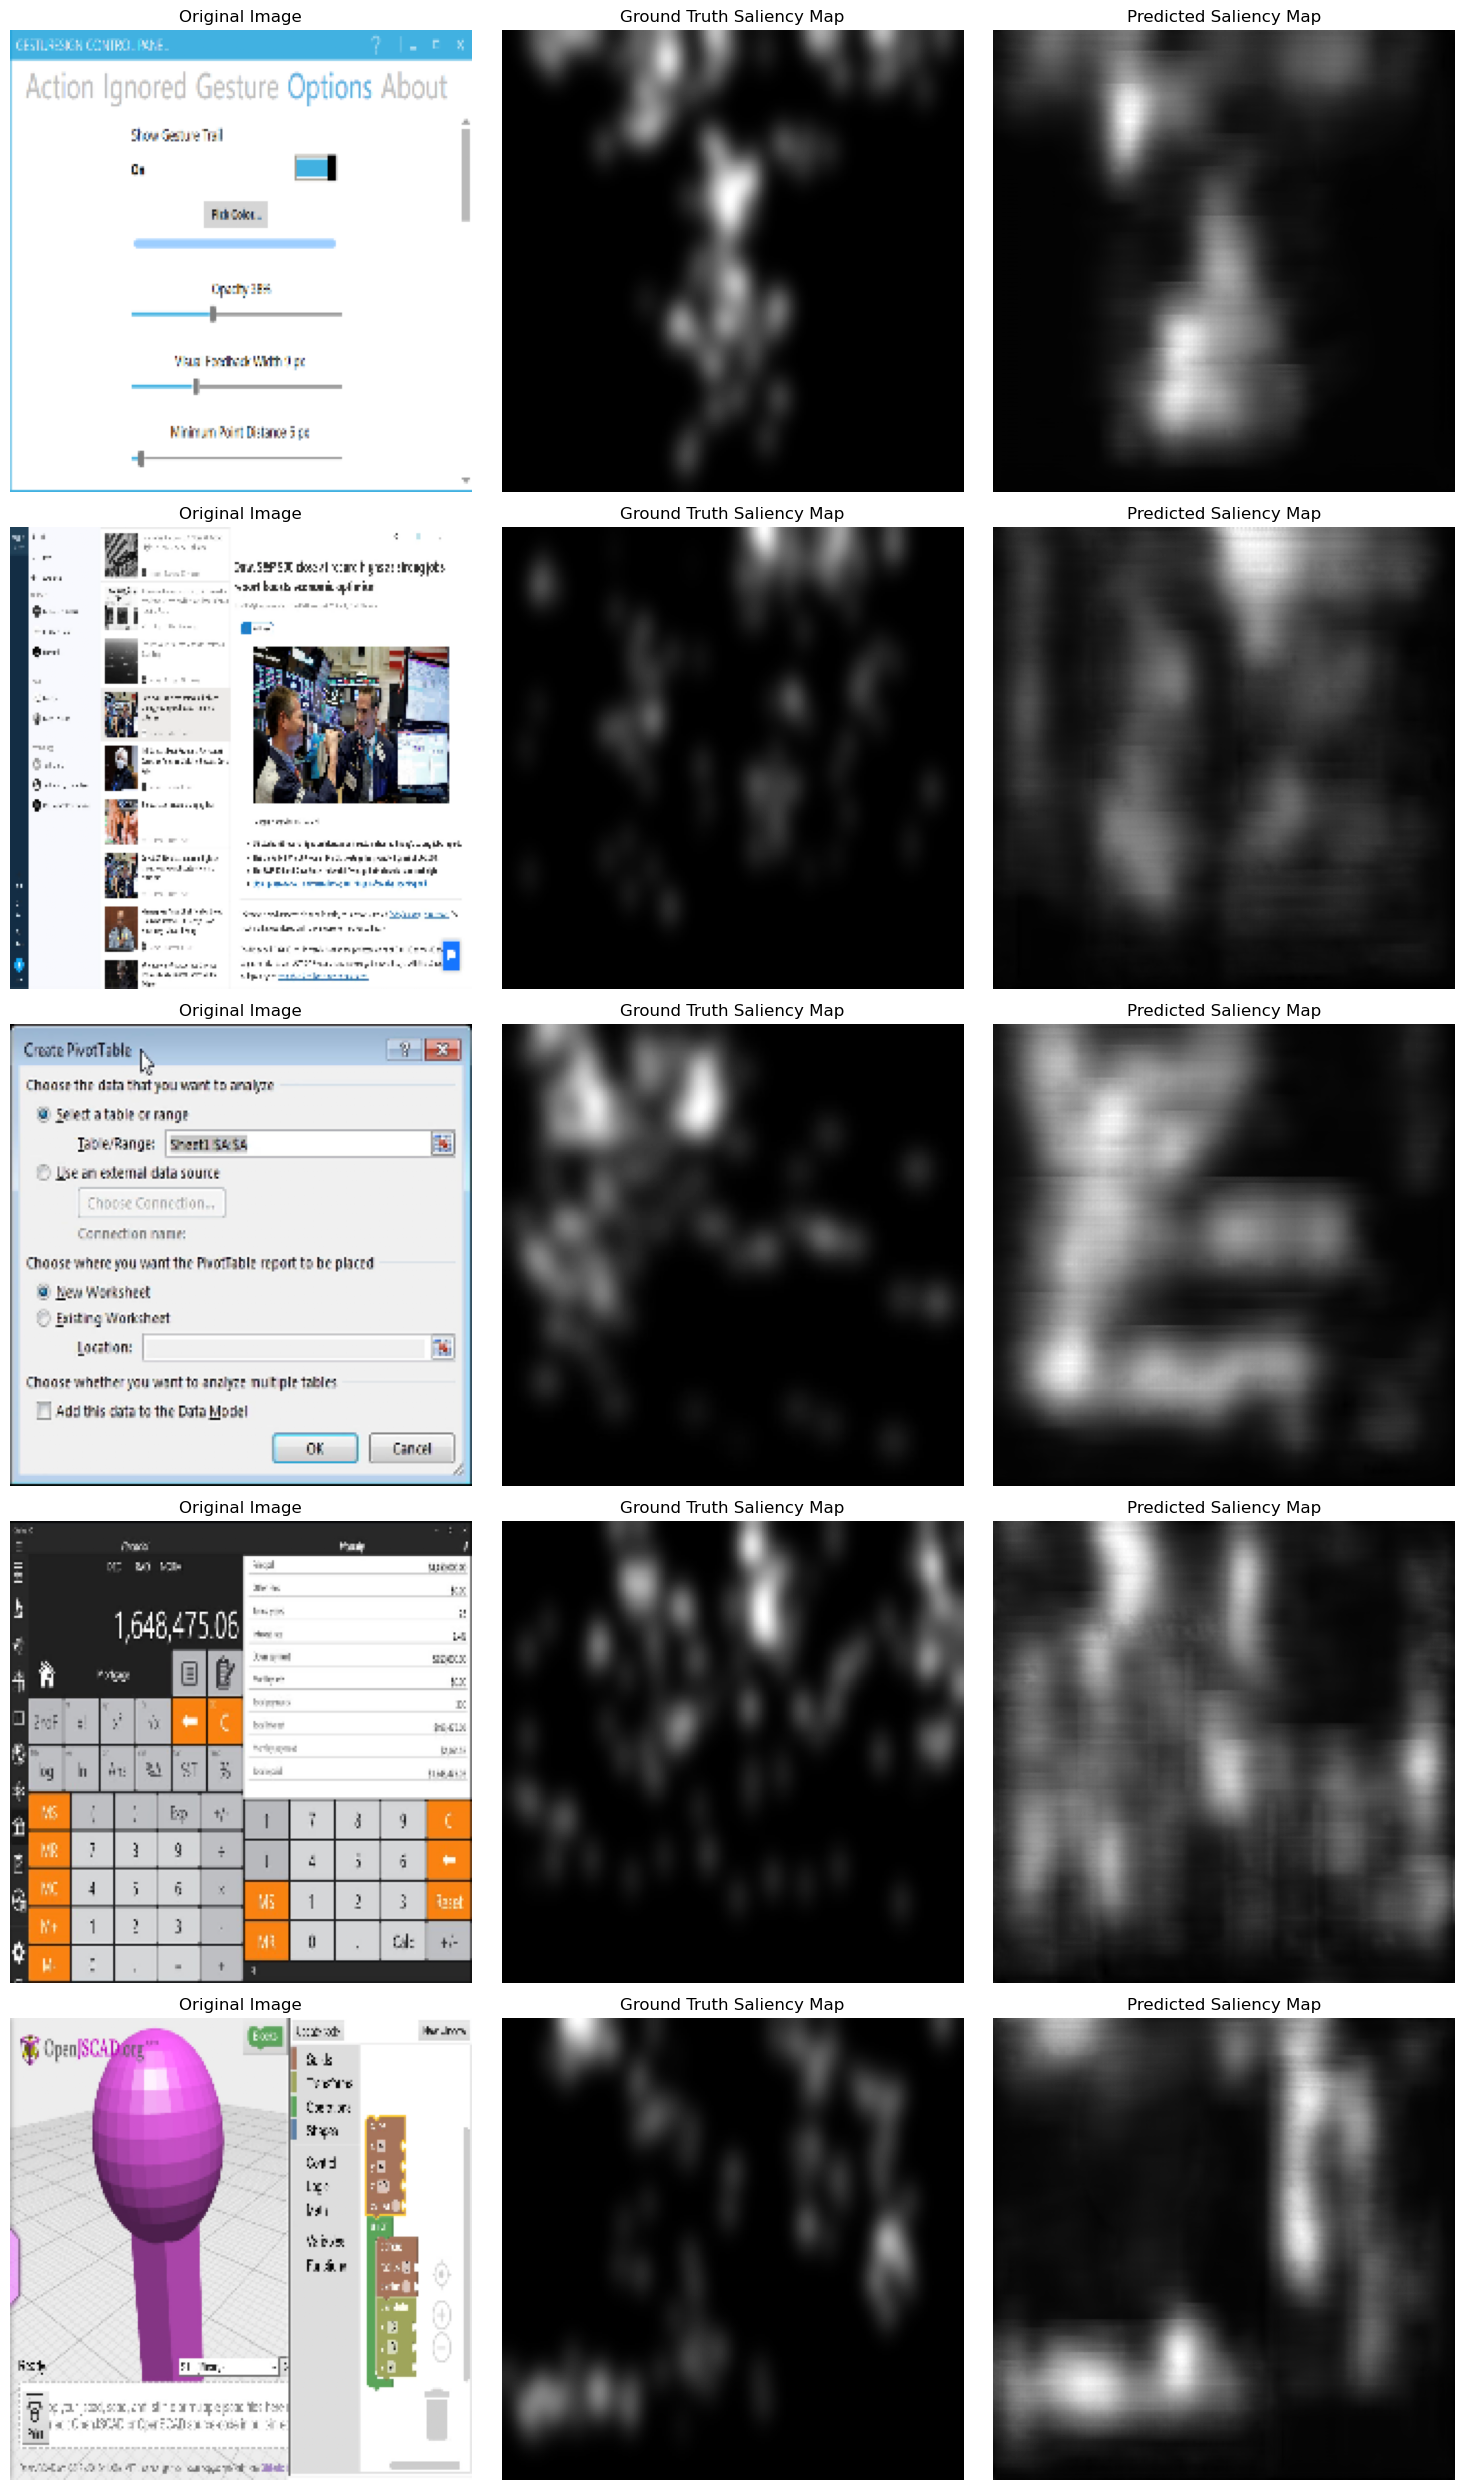

In [ ]:
visualize_results(UMSI_simple, test_data_gen, num_samples=5) # 5 random test examples